In [ ]:
from dolfin import *
from mshr import *
import numpy
from datetime import datetime
import csv
import os
import sys
import matplotlib.pyplot as plt

#-------------------------------------------------------
# USER DEFINED PARAMETERS:
# Set the following parameters according to your problem

# Choose one IO format
#fileio = 'xdmf'
fileio = 'pvd'

# Space dimensions
nsd    = 2

# Number of immersed balls
nballs = 3

# Computational domain
Lx     = 2.0
Ly     = 2.0

# Balls initial positions
centers = [[0.5,1], [1,1.5], [1.5,1]]
radii   = [0.25, 0.15, 0.25]

xc = [[] for ib in range(nballs)]
for ib in range(nballs):
   [xc[ib].append(centers[ib][j]) for j in range(nsd)]

# Thermal conductivity
kA,kB = 1.2, 10000.2
condA, condB = Constant(kA), Constant(kB)

# Volumetric source
f = Constant(0)

# Boundary temperatures
Tleft   = Constant(100)
Tright  = Constant(0)

# Variational problem: Preliminaries
# Finite elements
order = 2
Pk = FiniteElement("Lagrange", 'triangle', order)

# Dirichlet boundary conditions
# Subdomains
class left(SubDomain):
   def inside(self, x, on_boundary):
       return on_boundary and abs(x[0]-0.0) < DOLFIN_EPS

class right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]-Lx) < DOLFIN_EPS
            
class top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]-0.0) < DOLFIN_EPS
            
class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]-Ly) < DOLFIN_EPS

class ball(SubDomain):
   def __init__(self,xc,yc,R):
      self.xc = xc
      self.yc = yc
      self.R = R
      SubDomain.__init__(self) # Call base class constructor!
   def inside (self, x, on_boundary ):
      r = sqrt ( ( x[0] - self.xc ) ** 2 + ( x[1] - self.yc ) ** 2 )
      return ( on_boundary and ( r < self.R * 1.1 ) )

left   = left()
right  = right()
top    = top()
bottom = bottom()

# IO
dir_ = './results'
if not os.path.exists(dir_):
    os.mkdir(dir_)

if fileio == 'xdmf':
    filex = XDMFFile(dir_+'/sol.xdmf')
    filex.parameters['functions_share_mesh'] = True
    filex.parameters['rewrite_function_mesh'] = True
    filex.parameters["flush_output"] = True
elif fileio == 'pvd': 
    ufile_pvd  = File(dir_+"/temperature.pvd")
    domfile_pvd = File(dir_+"/auxfunc.pvd")

# Begin loop over time steps
startTime = datetime.now()
print('\n   ::> Begin computations')

#----------------------------------------------
# Mesh generation

if(nsd == 2):
   domain = Rectangle(Point(0.0,0.0), Point(Lx,Ly))
   for ib in range(nballs):
      inc = Circle(Point(xc[ib][0],xc[ib][1]),radii[ib])
      domain.set_subdomain(ib+1, inc)
else:
   sys.exit("nsd.eq.3 not implemented")
    
mesh = generate_mesh ( domain, 40 )
print("    |-Mesh done")
print("    |--Number of vertices = "+str(mesh.num_vertices()))
print("    |--Number of cells = "+str(mesh.num_cells()))
print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))  

# Finite element space
W = FunctionSpace(mesh, Pk)

# Dirichlet restrictions on W
bcs = []
# Fixed temperature: left and right
bcleft  = DirichletBC(W, Tleft, left)
bcs.append(bcleft)
bcright  = DirichletBC(W, Tright, right)
bcs.append(bcright)
    
#-----------------------------------------
# Variational formulation: Poisson problem

u = TrialFunction(W)
v = TestFunction(W)

# Add the different inclusions to the domain of integration
funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
dx = Measure("dx")(subdomain_data=funcdom)

dxf = dx(1)
for ib in range(nballs-1):
   dxf = dxf + dx(ib+2)

# Bilinear and linear forms
a = inner(condA*grad(u), grad(v))*dx(0) + inner(condB*grad(u), grad(v))*dxf   
L = f*v*dx

#---------
# Solution

w = Function(W)
solve(a == L, w, bcs)

# IO
w.rename("T","T")
if fileio == 'xdmf':
  filex.write(w, 0)
  filex.write(funcdom, 0)
elif fileio == 'pvd':
  ufile_pvd << w
  domfile_pvd << funcdom

elapsed_time = datetime.now() - startTime
print('\n  ::> Elapsed time: ', str(elapsed_time), '\n')

if fileio == 'xdmf':
    filex.close()



# Make sure to understand the code

In [29]:
from dolfin import *
from mshr import *
import numpy
from datetime import datetime
import csv
import os
import sys
import matplotlib.pyplot as plt

#-------------------------------------------------------
# USER DEFINED PARAMETERS:
# Set the following parameters according to your problem

# Choose one IO format
#fileio = 'xdmf'
fileio = 'pvd'

# Space dimensions
nsd    = 2

# Number of immersed balls
nballs = 3

# Computational domain
Lx     = 2.0
Ly     = 2.0

# Balls initial positions
centers = [[0.5,1], [1,1.5], [1.5,1]]
radii   = [0.25, 0.15, 0.25]

xc = [[] for ib in range(nballs)]
for ib in range(nballs):
   [xc[ib].append(centers[ib][j]) for j in range(nsd)]

# Thermal conductivity
kA, kB = 1.0, 1.0
condA, condB = Constant(kA), Constant(kB)

# Volumetric source
f = Constant(0)

# Boundary temperatures
Tleft   = Constant(100)
Tright  = Constant(0)

# Variational problem: Preliminaries
# Finite elements
order = 1
Pk = FiniteElement("Lagrange", 'triangle', order)

# Dirichlet boundary conditions
# Subdomains
class left(SubDomain):
    def inside(self, x, on_boundary):
       return on_boundary and abs(x[0]-0.0) < DOLFIN_EPS

class right(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]-Lx) < DOLFIN_EPS
            
class top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]-0.0) < DOLFIN_EPS
            
class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]-Ly) < DOLFIN_EPS

class ball(SubDomain):
   def __init__(self,xc,yc,R):
      self.xc = xc
      self.yc = yc
      self.R = R
      SubDomain.__init__(self) # Call base class constructor!
   def inside (self, x, on_boundary ):
      r = sqrt ( ( x[0] - self.xc ) ** 2 + ( x[1] - self.yc ) ** 2 )
      return ( on_boundary and ( r < self.R * 1.1 ) )

left   = left()
right  = right()
top    = top()
bottom = bottom()

# IO
dir_ = './results'
if not os.path.exists(dir_):
    os.mkdir(dir_)

if fileio == 'xdmf':
    filex = XDMFFile(dir_+'/sol.xdmf')
    filex.parameters['functions_share_mesh'] = True
    filex.parameters['rewrite_function_mesh'] = True
    filex.parameters["flush_output"] = True
elif fileio == 'pvd': 
    ufile_pvd  = File(dir_+"/temperature.pvd")
    domfile_pvd = File(dir_+"/auxfunc.pvd")

# Begin loop over time steps
startTime = datetime.now()
print('\n   ::> Begin computations')

#----------------------------------------------
# Mesh generation

if(nsd == 2):
   domain = Rectangle(Point(0.0,0.0), Point(Lx,Ly))
   for ib in range(nballs):
      inc = Circle(Point(xc[ib][0],xc[ib][1]),radii[ib])
      domain.set_subdomain(ib+1, inc)
else:
   sys.exit("nsd.eq.3 not implemented")
    
mesh = generate_mesh ( domain, 40 )
print("    |-Mesh done")
print("    |--Number of vertices = "+str(mesh.num_vertices()))
print("    |--Number of cells = "+str(mesh.num_cells()))
print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))  

# Finite element space
W = FunctionSpace(mesh, Pk)

# Dirichlet restrictions on W
bcs = []
# Fixed temperature: left and right
bcleft  = DirichletBC(W, Tleft, left)
bcs.append(bcleft)
bcright  = DirichletBC(W, Tright, right)
bcs.append(bcright)
    
#-----------------------------------------
# Variational formulation: Poisson problem

u = TrialFunction(W)
v = TestFunction(W)

# Add the different inclusions to the domain of integration
funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
dx = Measure("dx")(subdomain_data=funcdom)

dxf = dx(1)
for ib in range(nballs-1):
   dxf = dxf + dx(ib+2)

# Bilinear and linear forms
a = inner(condA*grad(u), grad(v))*dx(0) + inner(condB*grad(u), grad(v))*dxf   
L = f*v*dx

#---------
# Solution

w = Function(W)
solve(a == L, w, bcs)

# IO
w.rename("T","T")
if fileio == 'xdmf':
  filex.write(w, 0)
  filex.write(funcdom, 0)
elif fileio == 'pvd':
  ufile_pvd << w
  domfile_pvd << funcdom

elapsed_time = datetime.now() - startTime
print('\n  ::> Elapsed time: ', str(elapsed_time), '\n')

if fileio == 'xdmf':
    filex.close()




   ::> Begin computations
    |-Mesh done
    |--Number of vertices = 2538
    |--Number of cells = 4906
    |--Cell size hmax,hmin = 0.0636 0.032

  ::> Elapsed time:  0:00:00.136402 



# and 3 Compute the error in the L2(Ω) and H1 (Ω)-norms

------------------------------------

In [7]:
ue = Expression('Tleft -( Tleft - Tright )*x [0]/ Lx', degree=1, Tleft=100,
                Tright=0, Lx=2)

gradue = Expression(('-(Tleft - Tright )/Lx','0'), degree=0, Tleft=100,
                    Tright=0, Lx =2)
w = Function (W)
solve (a == L, w, bcs)
errorL2 = assemble ((w - ue )**2*dx)
errorH1 = errorL2 + assemble ((grad (w) - gradue)**2* dx)
print (" | - Errors =", sqrt ( errorL2 ) , sqrt ( errorH1 ) )


 | - Errors = 8.187724245457061e-13 2.0689319122251636e-12


# Run the script setting different values for κB (variable kB in the code)

In [68]:
dx = Measure("dx")( subdomain_data = funcdom )
dxf = dx(1)
for ib in range (nballs -1) :
    dxf = dxf + dx (ib +2)

L2_errors = []
H1_errors = []
    
for kB in np.arange(0.1, 5, 0.45):# np.linspace(1, 10, 10): #[1, 2 , 3, 5, 7, 8, 10, 24]:
    condB = Constant (kB)
    # Bilinear and linear forms
    a = inner (condA * grad (u) , grad(v )) * dx (0)
    a = a + inner (condB * grad (u) , grad(v )) * dxf
    L = f * v * dx
    # Solution
    w = Function (W)
    solve (a == L, w, bcs)
    errorL2 = assemble ((w - ue )**2*dx)
    errorH1 =errorL2 + assemble ((grad (w) - gradue)**2* dx)
    L2_errors.append(sqrt(errorL2))
    H1_errors.append(sqrt(errorH1))
    print (" | - Errors =", sqrt(errorL2), sqrt(errorH1))
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim ()-1)
    boundaries.set_all(0)
    left.mark(boundaries, 1)
    right.mark(boundaries, 3)
    ds = Measure("ds")(subdomain_data=boundaries)
    n = FacetNormal(mesh)
    Qin = assemble(kA * inner(grad(w), n) * ds(1))
    Qout = assemble(kA * inner(grad(w), n) * ds(3))

    print (" | -- Q_in =",  Qin, ", Q_out = ", Qout)
    ufile_pvd  = File(dir_ +"/temperature_"+ str(kB)+ ".pvd")
    ufile_pvd << w


 | - Errors = 3.739043590623411 30.123925617816344
 | -- Q_in = 83.97613588569673 , Q_out =  -84.04144456330336
 | - Errors = 1.4457182020408066 11.730113979949374
 | -- Q_in = 93.73076546581673 , Q_out =  -93.75650066092336
 | - Errors = 1.7195909097030054e-12 3.550717667144812e-12
 | -- Q_in = 99.99999999999525 , Q_out =  -100.00000000000288
 | - Errors = 1.0008696582682037 8.169247211457993
 | -- Q_in = 104.37843763419757 , Q_out =  -104.36035497735115
 | - Errors = 1.7364455597214181 14.195014010632626
 | -- Q_in = 107.61211954443469 , Q_out =  -107.58063391627985
 | - Errors = 2.300414925400031 18.826364510202392
 | -- Q_in = 110.09907556928948 , Q_out =  -110.05725781881326
 | - Errors = 2.746781375243333 22.49845741406472
 | -- Q_in = 112.07160058627927 , Q_out =  -112.02157454176243
 | - Errors = 3.1089600273355362 25.48196440013453
 | -- Q_in = 113.67454648315949 , Q_out =  -113.61784210756579
 | - Errors = 3.408768074981435 27.954276001522317
 | -- Q_in = 115.0029860529661 , 

In [69]:
import pandas as pd
df = pd.DataFrame(np.array([L2_errors, H1_errors]).T, columns=['L2', 'H1'])
df

,L2,H1
0,3.739044e+00,3.012393e+01
1,1.445718e+00,1.173011e+01
2,1.719591e-12,3.550718e-12
3,1.000870e+00,8.169247e+00
4,1.736446e+00,1.419501e+01
5,2.300415e+00,1.882636e+01
6,2.746781e+00,2.249846e+01
7,3.108960e+00,2.548196e+01
8,3.408768e+00,2.795428e+01
9,3.661068e+00,3.003658e+01


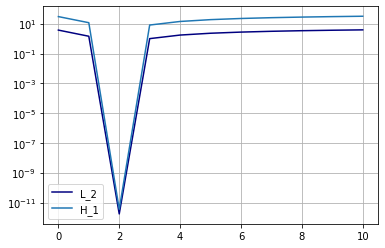

In [70]:
plt.plot(L2_errors, c='navy', label='L_2')
plt.plot(H1_errors, label='H_1')
#plt.gca().set(xscale='log')
plt.gca().set(yscale='log')

plt.legend()
plt.grid()
plt.show()

# Implement the computation of the amount of heat coming in and out the domain through the left and right boundaries

In [62]:
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim ()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 3)
ds = Measure("ds")(subdomain_data=boundaries)
n = FacetNormal(mesh)
Qin = assemble(kA * inner(grad(w), n) * ds(1))
Qout = assemble(kA * inner(grad(w), n) * ds(3))

print (" | -- Q_in =",  Qin, ", Q_out = ", Qout)

 | -- Q_in = 117.07866211448135 , Q_out =  -117.01539180455815


# Let consider κB >> κA, such that the temperature on each circular region is approximately constant.

In [64]:
faux = Function(W)
faux = interpolate(Constant(1.0), W)
avgT = []
for ib in range (nballs) :
    area = assemble (faux * dx(ib + 1))
    avgT.append(assemble(w * dx(ib + 1))/area)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [65]:
avgT

[74.49619216145808, 50.0006226102074, 25.504711418338594]

In [76]:
orders = [1, 2, 3, 4]
df_os = []
set_log_level(50)
for o in orders:
    print ("| -- Order =",  o)
    order = o
    Pk = FiniteElement("Lagrange", 'triangle', order)
    if(nsd == 2):
       domain = Rectangle(Point(0.0,0.0), Point(Lx,Ly))
       for ib in range(nballs):
          inc = Circle(Point(xc[ib][0],xc[ib][1]),radii[ib])
          domain.set_subdomain(ib+1, inc)
    else:
       sys.exit("nsd.eq.3 not implemented")

    mesh = generate_mesh (domain, 40 )
    W = FunctionSpace(mesh, Pk)

    # Dirichlet restrictions on W
    bcs = []
    # Fixed temperature: left and right
    bcleft  = DirichletBC(W, Tleft, left)
    bcs.append(bcleft)
    bcright  = DirichletBC(W, Tright, right)
    bcs.append(bcright)

    #-----------------------------------------
    # Variational formulation: Poisson problem

    u = TrialFunction(W)
    v = TestFunction(W)

    # Add the different inclusions to the domain of integration
    funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
    dx = Measure("dx")(subdomain_data=funcdom)

    dxf = dx(1)
    for ib in range(nballs-1):
       dxf = dxf + dx(ib+2)

    # Bilinear and linear forms
    a = inner(condA*grad(u), grad(v))*dx(0) + inner(condB*grad(u), grad(v))*dxf   
    L = f*v*dx

    dx = Measure("dx")( subdomain_data = funcdom )
    dxf = dx(1)
    for ib in range (nballs -1) :
        dxf = dxf + dx (ib +2)

    L2_errors = []
    H1_errors = []

    for kB in np.arange(0.1, 2, 0.45):# np.linspace(1, 10, 10): #[1, 2 , 3, 5, 7, 8, 10, 24]:
        condB = Constant (kB)
        # Bilinear and linear forms
        a = inner (condA * grad (u) , grad(v )) * dx (0)
        a = a + inner (condB * grad (u) , grad(v )) * dxf
        L = f * v * dx
        # Solution
        w = Function (W)
        solve (a == L, w, bcs)
        errorL2 = assemble ((w - ue )**2*dx)
        errorH1 =errorL2 + assemble ((grad (w) - gradue)**2* dx)
        L2_errors.append(sqrt(errorL2))
        H1_errors.append(sqrt(errorH1))
        print (" | - Errors =", sqrt(errorL2), sqrt(errorH1))
        boundaries = MeshFunction("size_t", mesh, mesh.topology().dim ()-1)
        boundaries.set_all(0)
        left.mark(boundaries, 1)
        right.mark(boundaries, 3)
        ds = Measure("ds")(subdomain_data=boundaries)
        n = FacetNormal(mesh)
        Qin = assemble(kA * inner(grad(w), n) * ds(1))
        Qout = assemble(kA * inner(grad(w), n) * ds(3))

        print ("   | -- Q_in =",  Qin, ", Q_out = ", Qout)
        print( )
        ufile_pvd  = File(dir_ +"/temperature_"+ str(kB)+ ".pvd")
        ufile_pvd << w
    df_os.append(pd.DataFrame(np.array([L2_errors, H1_errors]).T,
                              columns=['L2', 'H1']))

| -- Order = 1
 | - Errors = 3.7385704411183145 30.115777245413284
   | -- Q_in = 83.9780482303837 , Q_out =  -84.03657995218649

 | - Errors = 1.4456981510265137 11.728473568604993
   | -- Q_in = 93.731014604393 , Q_out =  -93.75404920375765

 | - Errors = 7.953760106510414e-13 2.031340141255189e-12
   | -- Q_in = 99.99999999999697 , Q_out =  -100.0000000000012

 | - Errors = 1.0009249797264934 8.168846875383538
   | -- Q_in = 104.37854013496916 , Q_out =  -104.36237739791706

 | - Errors = 1.7365657937175543 14.19460963712241
   | -- Q_in = 107.61241643583308 , Q_out =  -107.58428556040985

| -- Order = 2
 | - Errors = 3.775289466379585 30.46531462953904
   | -- Q_in = 83.91725505321418 , Q_out =  -83.91637456229122

 | - Errors = 1.4537679042174465 11.81491704448071
   | -- Q_in = 93.7296014664774 , Q_out =  -93.72922219042489

 | - Errors = 1.3842379836013056e-10 2.643797540742883e-10
   | -- Q_in = 99.9999999994919 , Q_out =  -100.0000000002513

 | - Errors = 1.0026744921550461 8.

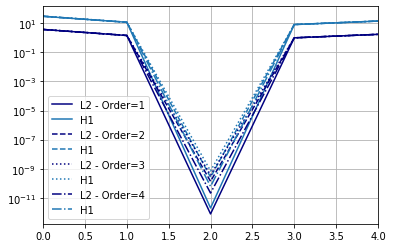

In [84]:
ls = ['-', '--', ':', '-.']
plt.figure()
for i, df in enumerate(df_os):
    df.plot(y='L2', c='navy', ax=plt.gca(), ls=ls[i], label='L2 - Order='+str(i+1))
    df.plot(y='H1', c='C0', ax=plt.gca(), ls=ls[i])
    
plt.gca().set(yscale='log')

plt.legend()
plt.grid()
plt.show()